<a href="https://www.kaggle.com/code/cemkesici/melbourne-housing-market?scriptVersionId=147861871" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df= pd.read_csv("/kaggle/input/melbourne-housing-market/Melbourne_housing_FULL.csv")

In [4]:
def check_dataframe(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Duplicated #####################")
    print(dataframe.duplicated().sum())
    print("##################### Describe #####################")
    print(dataframe.describe().T)

In [5]:
check_dataframe(df)

##################### Shape #####################
(34857, 21)
##################### Types #####################
Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object
##################### Head #####################
       Suburb          Address  Rooms Type       Price Method SellerG  \
0  Abbotsford    68 Studley St      2    h         NaN     SS  Jellis   
1  Abbotsford     85 Turner St      2    h 1480000.000      S  Biggin   
2  Abbotsford  25 Bloomburg St      2    h 1035000.000      S  Biggin   

       

In [6]:
#columns_to_drop = ["Lattitude","Longtitude"]
#df = df.drop(columns_to_drop, axis=1)
#check_dataframe(df)

In [7]:
def grab_col_names(df, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    
    cat_cols = cat_cols + num_but_cat
    
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations(Rows): {df.shape[0]}")
    print(f"Variables(Columns): {df.shape[1]}\n")
    print(f'cat_cols: {len(cat_cols)}\nnum_cols: {len(num_cols)}\ncat_but_car: {len(cat_but_car)}\nnum_but_cat: {len(num_but_cat)}')
    print(f"\ncat_cols: {cat_cols}\nnum_cols: {num_cols}\ncat_but_car: {cat_but_car}\n")

    print(f"\ncat_cols data types:\n\n{df[cat_cols].dtypes}\n\nnum_cols data types:\n\n{df[num_cols].dtypes}\n\ncat_but_car data types:\n\n{df[cat_but_car].dtypes}")
    
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations(Rows): 34857
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


In [8]:
######################################
# Kategorik Değişken Analizi (Analysis of Categorical Variables)
######################################
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)

Observations(Rows): 34857
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


In [9]:
######################################
# Sayısal Değişken Analizi (Analysis of Numerical Variables)
######################################
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(df, col, False)

Observations(Rows): 34857
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


In [10]:
######################################
# Hedef Değişken Analizi (Analysis of Target Variable)
######################################
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"Price",col)


Observations(Rows): 34857
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


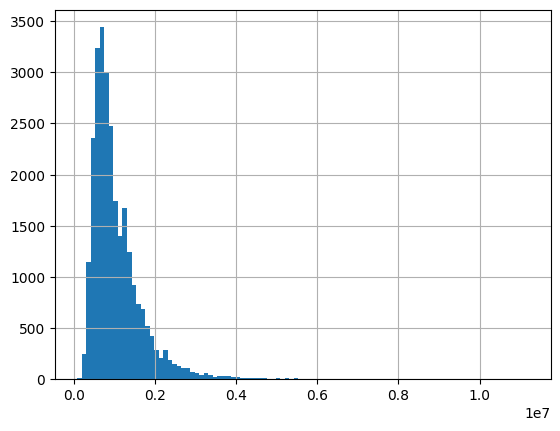

In [11]:
# Bağımlı değişkenin incelenmesi
df["Price"].hist(bins=100)
plt.show()

In [12]:
def Clear_Duplicates(df):
    duplicates = df.duplicated()
    df = df[~duplicates]
    return df
df=Clear_Duplicates(df)

Observations(Rows): 34856
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


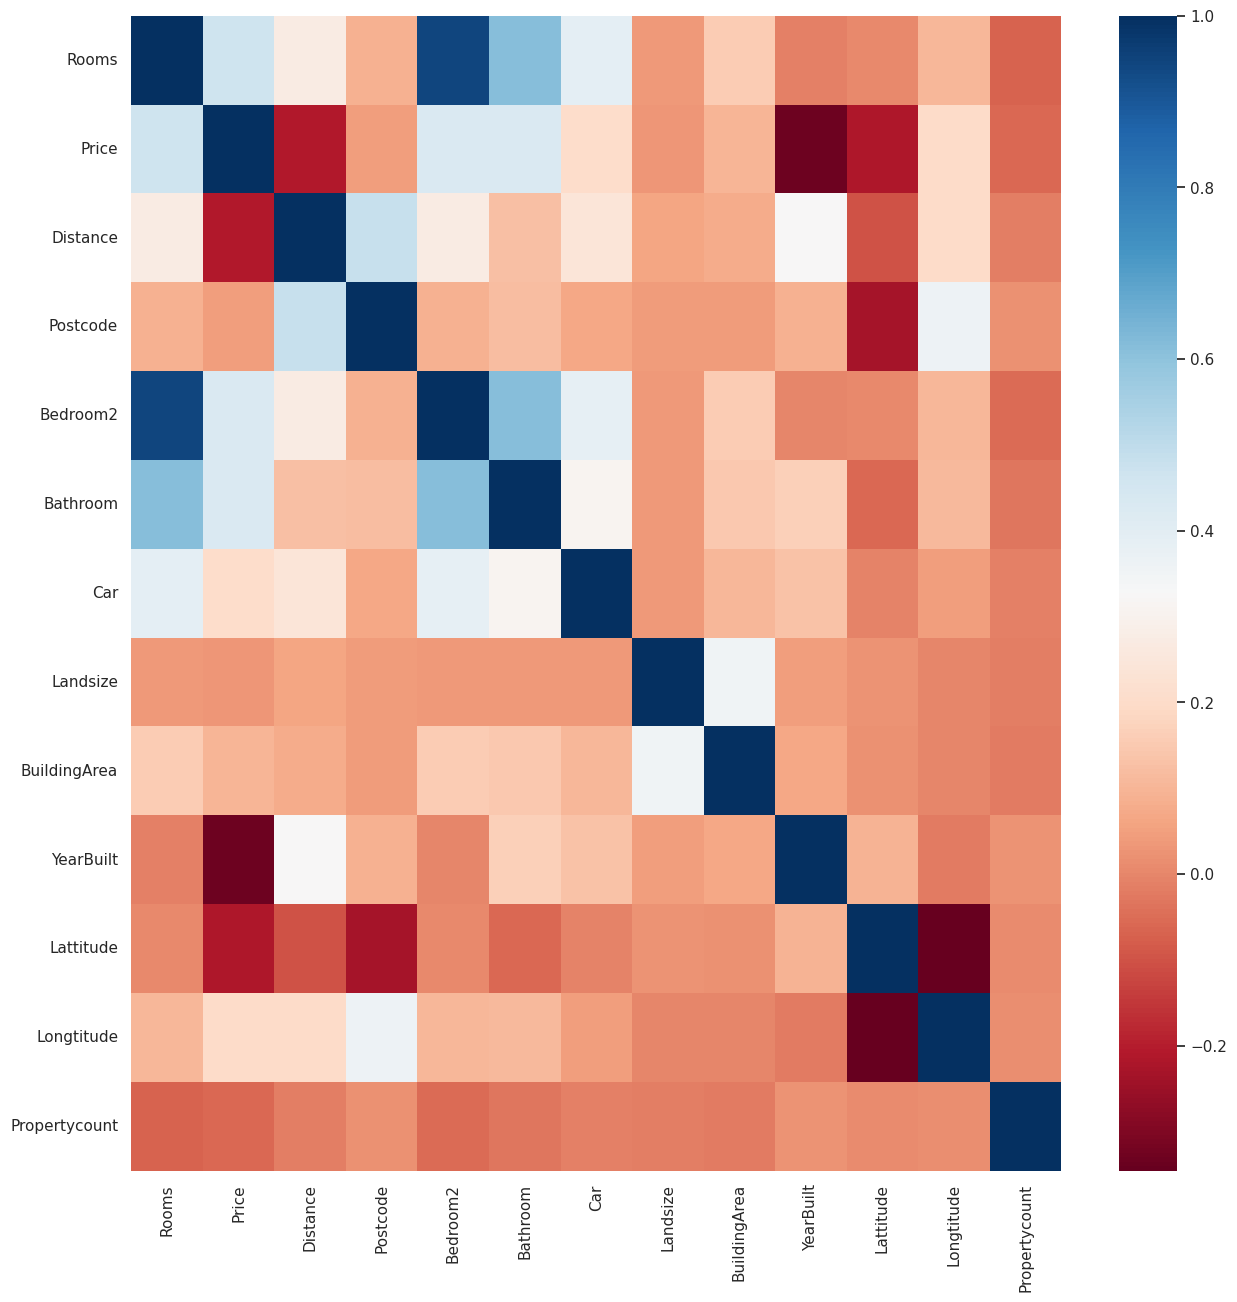

['Bedroom2']

In [13]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def high_correlated_cols(df, col, plot=False, corr_th=0.70):
    corr = df[col].corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
        
    return drop_list

high_correlated_cols(df, num_cols, plot=True)

In [14]:
#df = df.drop('Bedroom2', axis=1)
#check_dataframe(df)

In [15]:
######################################
# Aykırı Değer Analizi
######################################
cat_cols, num_cols, cat_but_car = grab_col_names(df)

# Aykırı değerlerin baskılanması
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in num_cols:
    if col != "Price":
      print("Outlier Cols: ", col, check_outlier(df, col))

# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    return dataframe

for col in num_cols:
    if col != "Price":
        df=replace_with_thresholds(df,col)

Observations(Rows): 34856
Variables(Columns): 21

cat_cols: 3
num_cols: 13
cat_but_car: 5
num_but_cat: 0

cat_cols: ['Type', 'Method', 'Regionname']
num_cols: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type          object
Method        object
Regionname    object
dtype: object

num_cols data types:

Rooms              int64
Price            float64
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object


In [16]:
######################################
# Eksik Değer Analizi
######################################

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)

               n_miss  ratio
BuildingArea    21115 60.580
YearBuilt       19306 55.390
Landsize        11810 33.880
Car              8728 25.040
Bathroom         8226 23.600
Bedroom2         8217 23.570
Lattitude        7976 22.880
Longtitude       7976 22.880
Price            7609 21.830
CouncilArea         3  0.010
Regionname          3  0.010
Propertycount       3  0.010
Distance            1  0.000
Postcode            1  0.000


In [17]:
def quick_missing_imp(df, num_method="median", cat_length=20, target="Price"):
    """"variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")"""
    
   # df['Bathroom'].fillna(df['Bathroom'].mode()[0], inplace=True)
    #df['Car'].fillna(df['Car'].mode()[0], inplace=True)
    
    # Replace missing room values with Bedroom2 if any.
    #missing_room_idx=df.loc[df["Rooms"].isna()]["Rooms"].index.tolist()

    #for i in missing_room_idx:
     #   df.loc[i, "Rooms"] = df._get_value(i, "Bedroom2")
        
    #df.dropna(axis=0, subset="Rooms", inplace=True)
    #df.drop(columns=["Bedroom2"], inplace=True)
    df.dropna(inplace=True)
    return df

df = quick_missing_imp(df)

In [18]:
# Kategorik kolonların dağılımının incelenmesi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Price", cat_cols)

Observations(Rows): 8887
Variables(Columns): 21

cat_cols: 7
num_cols: 9
cat_but_car: 5
num_but_cat: 4

cat_cols: ['Type', 'Method', 'Regionname', 'Rooms', 'Bedroom2', 'Bathroom', 'Car']
num_cols: ['Price', 'Distance', 'Postcode', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type           object
Method         object
Regionname     object
Rooms           int64
Bedroom2      float64
Bathroom      float64
Car           float64
dtype: object

num_cols data types:

Price            float64
Distance         float64
Postcode         float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object
Type : 3
  

In [19]:
df["Type"] = np.where(df.Type.isin(["u", "t"]), "ut", df["Type"])
df["Regionname"] = np.where(df.Regionname.isin(["Northern Metropolitan", "Northern Victoria"]), "Northern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Eastern Metropolitan", "Eastern Victoria"]), "Eastern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Western Metropolitan", "Western Victoria"]), "Western", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["Southern Metropolitan"]), "Southern", df["Regionname"])
df["Regionname"] = np.where(df.Regionname.isin(["South-Eastern Metropolitan"]), "South-Eastern", df["Regionname"])
df["Method"] = np.where(df.Method.isin(["PN","SS","W","SA"]), "PN, SS, W, SA", df["Method"])
df["Car"] = np.where(df.Car.isin([5,6]),5, df["Car"])
df["Rooms"] = np.where(df.Rooms.isin([5,6,7]), 7, df["Rooms"])

In [20]:
# Kategorik kolonların dağılımının incelenmesi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "Price", cat_cols)

Observations(Rows): 8887
Variables(Columns): 21

cat_cols: 7
num_cols: 9
cat_but_car: 5
num_but_cat: 4

cat_cols: ['Type', 'Method', 'Regionname', 'Rooms', 'Bedroom2', 'Bathroom', 'Car']
num_cols: ['Price', 'Distance', 'Postcode', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']
cat_but_car: ['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea']


cat_cols data types:

Type           object
Method         object
Regionname     object
Rooms           int64
Bedroom2      float64
Bathroom      float64
Car           float64
dtype: object

num_cols data types:

Price            float64
Distance         float64
Postcode         float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
Lattitude        float64
Longtitude       float64
Propertycount    float64
dtype: object

cat_but_car data types:

Suburb         object
Address        object
SellerG        object
Date           object
CouncilArea    object
dtype: object
Type : 2
  

In [21]:
######################################
# GÖREV 3 : Yeni değişkenler oluşturunuz ve oluşturduğunuz yeni değişkenlerin başına 'NEW' ekleyiniz.
######################################

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
endYear = pd.to_datetime(df['YearBuilt'])
df["NEW_House_Age"] = datetime.now().date().year-endYear.dt.year

#del_Cols=['Suburb', 'Address', 'SellerG', 'Date', 'CouncilArea','YearBuilt']
df = df.drop(cat_but_car, axis=1)
df["NEW_Ratio_Area"] = df.Landsize / df.BuildingArea

df.columns = df.columns.str.upper()
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations(Rows): 8887
Variables(Columns): 18

cat_cols: 8
num_cols: 10
cat_but_car: 0
num_but_cat: 5

cat_cols: ['TYPE', 'METHOD', 'REGIONNAME', 'ROOMS', 'BEDROOM2', 'BATHROOM', 'CAR', 'NEW_HOUSE_AGE']
num_cols: ['PRICE', 'DISTANCE', 'POSTCODE', 'LANDSIZE', 'BUILDINGAREA', 'YEARBUILT', 'LATTITUDE', 'LONGTITUDE', 'PROPERTYCOUNT', 'NEW_RATIO_AREA']
cat_but_car: []


cat_cols data types:

TYPE              object
METHOD            object
REGIONNAME        object
ROOMS              int64
BEDROOM2         float64
BATHROOM         float64
CAR              float64
NEW_HOUSE_AGE      int32
dtype: object

num_cols data types:

PRICE             float64
DISTANCE          float64
POSTCODE          float64
LANDSIZE          float64
BUILDINGAREA      float64
YEARBUILT         float64
LATTITUDE         float64
LONGTITUDE        float64
PROPERTYCOUNT     float64
NEW_RATIO_AREA    float64
dtype: object

cat_but_car data types:

Series([], dtype: object)


In [22]:
df=Clear_Duplicates(df)
check_dataframe(df)

##################### Shape #####################
(8873, 18)
##################### Types #####################
ROOMS               int64
TYPE               object
PRICE             float64
METHOD             object
DISTANCE          float64
POSTCODE          float64
BEDROOM2          float64
BATHROOM          float64
CAR               float64
LANDSIZE          float64
BUILDINGAREA      float64
YEARBUILT         float64
LATTITUDE         float64
LONGTITUDE        float64
REGIONNAME         object
PROPERTYCOUNT     float64
NEW_HOUSE_AGE       int32
NEW_RATIO_AREA    float64
dtype: object
##################### Head #####################
   ROOMS TYPE       PRICE METHOD  DISTANCE  POSTCODE  BEDROOM2  BATHROOM  \
2      2    h 1035000.000      S     2.500  3067.000     2.000     1.000   
4      3    h 1465000.000     SP     2.500  3067.000     3.000     2.000   
6      4    h 1600000.000     VB     2.500  3067.000     3.000     1.000   

    CAR  LANDSIZE  BUILDINGAREA  YEARBUILT  LATTITUDE

In [23]:
num_cols = [col for col in num_cols if "PRICE" not in num_cols]
lbl_Cols= cat_cols+num_cols

# RobustScaler'ı tanımlamak
scaler = RobustScaler()
for col in num_cols:
    # Verileri ölçeklemek
    scaled_data = scaler.fit_transform(df[col])
    # Ölçeklenmiş veriyi yeni bir DataFrame olarak saklayın
    df = pd.DataFrame(scaled_data, columns=df.columns)

##################
#Label Encoding & One-Hot Encoding işlemlerinin uygulanması
##################

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=True)
    return dataframe

df = one_hot_encoder(df, lbl_Cols, drop_first=True)
check_dataframe(df)

##################### Shape #####################
(8873, 38)
##################### Types #####################
PRICE                       float64
DISTANCE                    float64
POSTCODE                    float64
LANDSIZE                    float64
BUILDINGAREA                float64
YEARBUILT                   float64
LATTITUDE                   float64
LONGTITUDE                  float64
PROPERTYCOUNT               float64
NEW_RATIO_AREA              float64
TYPE_ut                        bool
METHOD_PN, SS, W, SA           bool
METHOD_S                       bool
METHOD_SP                      bool
METHOD_VB                      bool
REGIONNAME_Northern            bool
REGIONNAME_South-Eastern       bool
REGIONNAME_Southern            bool
REGIONNAME_Western             bool
ROOMS_2                        bool
ROOMS_3                        bool
ROOMS_4                        bool
ROOMS_7                        bool
BEDROOM2_1.0                   bool
BEDROOM2_2.0             

In [24]:
##################################
# Modeli kurma işlemini gerçekleştiriniz.
##################################

# Sonsuz değerleri NaN ile değiştirme
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN değerleri temizleme
df.dropna(inplace=True)

X = df.drop('PRICE', axis=1)  # 'Price' sütunu hariç tüm sütunları seçiyoruz
y = df['PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)

In [25]:
models = {
    'Lasso': Lasso(),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'AdaBoostRegressor': AdaBoostRegressor(n_estimators = 20, learning_rate = 1, loss = 'exponential', random_state = 42)
}

In [26]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    scores=cross_val_score(model, X, y, cv=5)
    predict = model.predict(X_test)
    mae = mean_absolute_error(y_test, predict)
    mse = mean_squared_error(y_test, predict)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predict)
    
    print(f"##########{model_name}##########")
    print("Mean Absolute Error:  ",mae)
    print("Mean Seqaure Error:  ",mse)
    print("R Mean Seqaure Error:  ",rmse)
    print("R2:  ",r2)
    print("Model Skoru:  ",model.score(X_test,y_test))
    print("Croos Validation Skoru:  ",scores.mean())
    print("\n")

##########Lasso##########
Mean Absolute Error:   254501.6082766096
Mean Seqaure Error:   138737108029.73486
R Mean Seqaure Error:   372474.30519397557
R2:   0.6889432554602697
Model Skoru:   0.6889432554602697
Croos Validation Skoru:   0.6605085886287159


##########LinearRegression##########
Mean Absolute Error:   254517.28740919475
Mean Seqaure Error:   138749644329.33942
R Mean Seqaure Error:   372491.1332224425
R2:   0.6889151483402718
Model Skoru:   0.6889151483402718
Croos Validation Skoru:   0.6604108771938251


##########Ridge##########
Mean Absolute Error:   253950.16291539243
Mean Seqaure Error:   138244635826.01575
R Mean Seqaure Error:   371812.63537703466
R2:   0.6900474070649893
Model Skoru:   0.6900474070649893
Croos Validation Skoru:   0.660818584553376


##########ElasticNet##########
Mean Absolute Error:   265920.6324146027
Mean Seqaure Error:   168179633169.26086
R Mean Seqaure Error:   410097.10212248616
R2:   0.6229313848728616
Model Skoru:   0.6229313848728616
Cro